In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as kr
from keras import metrics, optimizers, regularizers
from scipy.stats import norm
from numpy.random import seed
seed(1)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


# VAE Model:

A variational autoencoder architecture (top), and an example of a data sample going through the VAE (bottom). Data is compressed in the encoder to create mean and standard deviation codings. The coding, z, is then created, with the addition of Gaussian noise, from the mean and standard deviation codings. The decoder uses the codings (or latent variables) z to reconstruct the input. 

In [3]:
##mount your google drive to colab notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Fetch the data directly from the location you saved it in your google drive
data = pd.read_csv('drive/My Drive/Datasets_handson/creditcard.csv') #load the dataset using pandas
data.head() # display the first 5 rows



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
data['Class'].value_counts() #count the number of classes (Normal and Fraud)

0    284315
1       492
Name: Class, dtype: int64

In [6]:
data = data.drop('Time',axis=1) #drop the time column

In [7]:
normal = data['Class']== 0 # create a dataframe for normal data
fraud= data['Class']!= 0  # create dataframe for fraud data

data_normal = data[normal]
data_fraud = data[fraud]

print(f"Normal count: {len(data_normal)}")
print(f"Fraud count: {len(data_fraud)}")

Normal count: 284315
Fraud count: 492


In [8]:
# convert dataframes to numpy arrays after dropping the label (class 0/1)
x_normal = data_normal.drop('Class',axis=1).values
y_normal = data_normal['Class'].values

x_fraud = data_fraud.drop('Class',axis=1).values
y_fraud = data_fraud['Class'].values

print(x_normal.shape, x_fraud.shape)
print(y_normal.shape, y_fraud.shape)

(284315, 29) (492, 29)
(284315,) (492,)


In [9]:
#train-test split for normal train and test data
from sklearn.model_selection import train_test_split
x_normal_train, x_normal_test = train_test_split(x_normal, test_size=0.25, random_state=40)
print(x_normal_train.shape, x_normal_test.shape)

(213236, 29) (71079, 29)


# Data Scaling using Min-Max scalar

In [10]:
import joblib
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler=MinMaxScaler()
x_norm_tr_scaled= scaler.fit_transform(x_normal_train) # fit_transform on train data
x_norm_tst_scaled= scaler.transform(x_normal_test) # transform on test data
x_fraud_scaled= scaler.transform(x_fraud) # transform on test data

# Define the sampling layer

In [11]:
def sampling(args):
    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z

This Sampling layer takes two inputs: z_mean (μ) and z_log_var (γ). It uses the function tf.random.normal() to sample a random vector (of the same shape as γ) from the Normal distribution, with mean 0 and standard deviation 1. Then it multiplies it by exp(γ / 2) (which is equal to σ, as you can verify), and finally it adds μ and returns the result. This samples a codings vector from the Normal distribution with mean μ and standard deviation σ.

# Set the hyperparameters

In [12]:
# data features
num_features = 29

# Training parameters.
batch_size = 32
epochs = 20

# Neural Network Parameters
hidden_1 = 128 # 1st layer number of neurons
hidden_2 = 64 # 2nd layer number of neurons
latent_dim = 2


# Define the encoder

(Using functional API)

In [13]:
inputs = kr.layers.Input(shape=(num_features, ), name='input') #num_features = 29 # number of input features
x1 = kr.layers.Dense(hidden_1, activation='relu')(inputs) ## First hidden layer
x2 = kr.layers.Dense(hidden_2, activation='relu')(x1) ##Second hidden layer
z_mean = kr.layers.Dense(latent_dim, name='z_mean')(x2) ### Latent layer
z_log_var = kr.layers.Dense(latent_dim, name='z_log_var')(x2) #latent_dim = 2

# Define the sampling/latent layer

Use reparameterization trick to push the sampling out as input

In [14]:
z = kr.layers.Lambda(sampling, name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = kr.Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 29)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  3840      ['input[0][0]']               
                                                                                                  
 dense_1 (Dense)             (None, 64)                   8256      ['dense[0][0]']               
                                                                                                  
 z_mean (Dense)              (None, 2)                    130       ['dense_1[0][0]']             
                                                                                            

# Define the decoder

In [15]:
latent_inputs = kr.layers.Input(shape=(latent_dim,), name='z_sampling')
x1 = kr.layers.Dense(hidden_2, activation='relu')(latent_inputs) ## First hidden layer
x2 = kr.layers.Dense(hidden_1, activation='relu')(x1) ## Second hidden layer
outputs = kr.layers.Dense(num_features, activation='sigmoid')(x2) #num_features = 29 # number of input features

# instantiate decoder model
decoder = kr.Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 64)                192       
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dense_4 (Dense)             (None, 29)                3741      
                                                                 
Total params: 12253 (47.86 KB)
Trainable params: 12253 (47.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Instantiate the VAE model

In [16]:
# # VAE model = encoder + decoder
# encoder(inputs) applies the encoder model to the input data inputs, which likely returns a list or tuple containing multiple elements, such as [z_mean, z_log_var, z]
#[2] represents the third element here (on index 2) which is z
outputs = decoder(encoder(inputs)[2])
vae = kr.Model(inputs, outputs, name='vae')

# Compute VAE Loss

During training, the VAE works to minimize its reconstruction loss (in our case we use mean squared error), and at the same time, force a Gaussian structure using a latent loss. The structure is achieved through the Kullback-Leibler (KL) divergence.

In [17]:
# Reconstruction loss
reconstruction_loss = tf.losses.mean_squared_error(inputs, outputs)
reconstruction_loss = reconstruction_loss * num_features

# KL Divergence loss
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
adam = optimizers.Adam(learning_rate=0.0001)
vae.compile(optimizer=adam) ##compile the model
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 29)]                 0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  12356     ['input[0][0]']               
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 29)                   12253     ['encoder[0][2]']             
                                                                                                

# Train the VAE Model

We can call vae.fit to start the training process. Note that we set x_norm_tr_scaled both as our features and targets, as is usual with autoencoders

In [18]:
history= vae.fit(x_norm_tr_scaled ,x_norm_tr_scaled, verbose = 1, batch_size=batch_size, epochs=epochs,shuffle=True,validation_split=0.2) #unsupervised learning because only x values used (no y values or labels)

Epoch 1/20
5331/5331 [==============================] - 49s 7ms/step - loss: 0.1158 - val_loss: 0.0557
Epoch 2/20
5331/5331 [==============================] - 28s 5ms/step - loss: 0.0559 - val_loss: 0.0553
Epoch 3/20
5331/5331 [==============================] - 28s 5ms/step - loss: 0.0557 - val_loss: 0.0553
Epoch 4/20
5331/5331 [==============================] - 29s 5ms/step - loss: 0.0557 - val_loss: 0.0552
Epoch 5/20
5331/5331 [==============================] - 29s 5ms/step - loss: 0.0557 - val_loss: 0.0552
Epoch 6/20
5331/5331 [==============================] - 29s 5ms/step - loss: 0.0556 - val_loss: 0.0552
Epoch 7/20
5331/5331 [==============================] - 32s 6ms/step - loss: 0.0556 - val_loss: 0.0552
Epoch 8/20
5331/5331 [==============================] - 30s 6ms/step - loss: 0.0556 - val_loss: 0.0552
Epoch 9/20
5331/5331 [==============================] - 29s 5ms/step - loss: 0.0556 - val_loss: 0.0552
Epoch 10/20
5331/5331 [==============================] - 29s 6ms/step - l

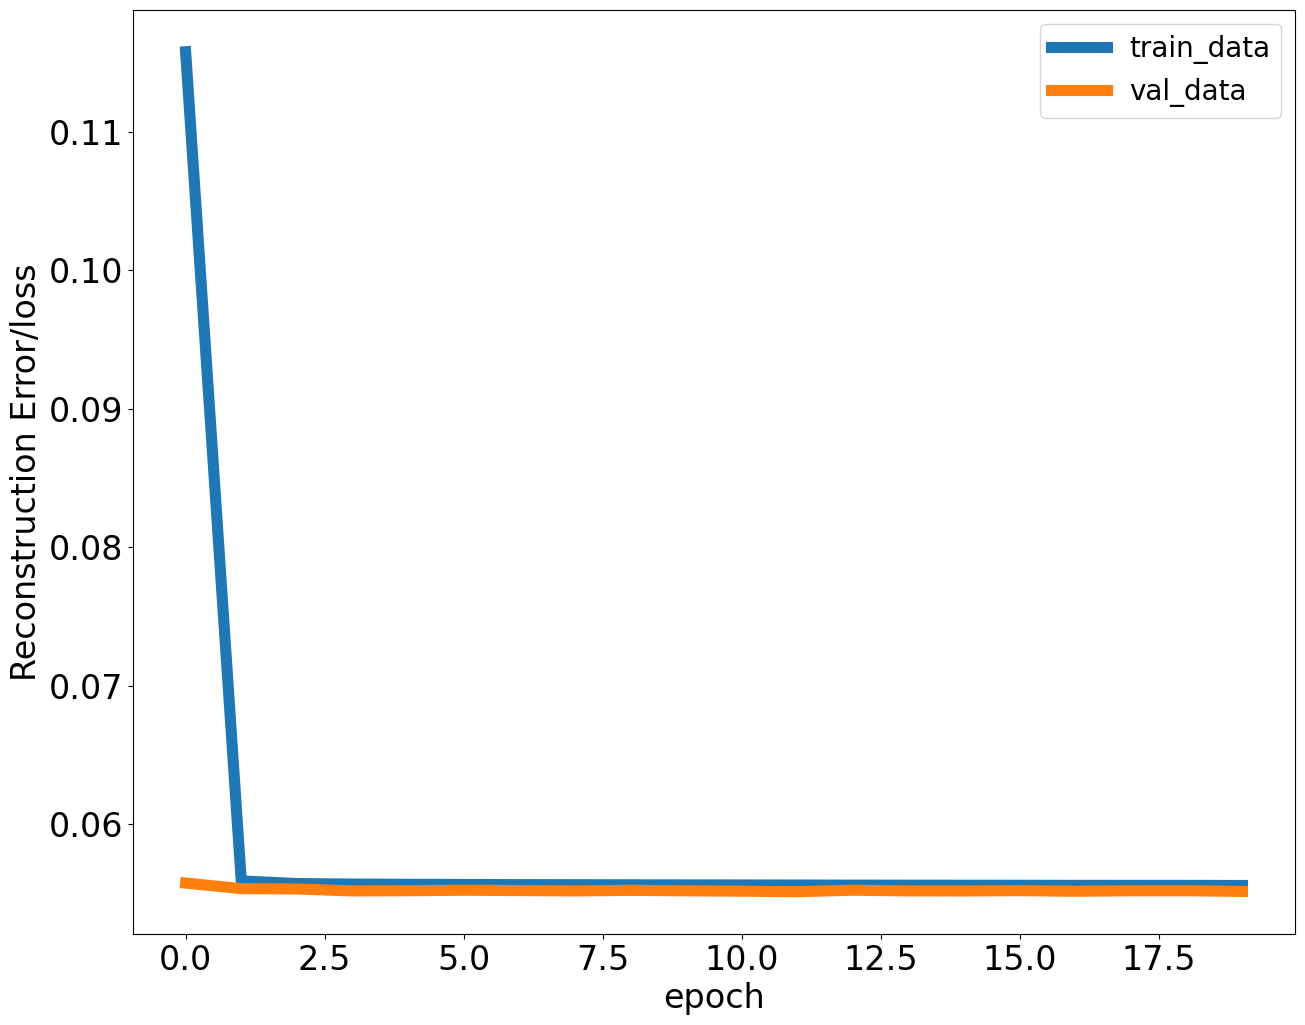

In [19]:
# loss plot train-validation
import matplotlib as mpl

mpl.rcParams['font.size'] = 24
plt.rcParams["figure.figsize"] = (15,12)
plt.plot(history.history['loss'],linewidth = 8)
plt.plot(history.history['val_loss'],linewidth = 8)
#plt.title('model loss',fontsize = 24)
plt.ylabel('Reconstruction Error/loss',fontsize = 24)
plt.xlabel('epoch',fontsize = 24)
plt.legend(['train_data', 'val_data'], loc='best',fontsize = 20)
plt.show()

# Make the predictions on different datasets (train/test)

In [20]:
from sklearn import metrics

pred1 = vae.predict(x_norm_tr_scaled) # predictions on train normal data
score1 = np.sqrt(metrics.mean_squared_error(pred1,x_norm_tr_scaled))

pred2 = vae.predict(x_norm_tst_scaled) # predictions on test normal data
score2 = np.sqrt(metrics.mean_squared_error(pred2,x_norm_tst_scaled))

pred3 = vae.predict(x_fraud_scaled) # predictions on test fraud data
score3 = np.sqrt(metrics.mean_squared_error(pred3,x_fraud_scaled))

print(f"Normal_training_data Score (RMSE): {score1}")
print(f"Normal_test_data_score Score (RMSE): {score2}")
print(f"Fraud_test_data_score (RMSE): {score3}")

16/16 [==============================] - 0s 2ms/step
Normal_training_data Score (RMSE): 0.043739964549274785
Normal_test_data_score Score (RMSE): 0.0437158282691264
Fraud_test_data_score (RMSE): 0.1700045967886472


# Combine the test data (normal) and fraud data





In [21]:
tst_obs = x_norm_tst_scaled.copy() # create a copy of normal data and save in tst_obs
print(tst_obs.shape)
tst_obs = np.append(tst_obs, x_fraud_scaled, axis=0) ##combine test normal and test fraud data
print(tst_obs.shape)
print(y_normal[0:71079].shape)


(71079, 29)
(71571, 29)
(71079,)


In [22]:
Y_obs = y_normal[0:71079].copy() # create a copy of normal labels and save in Y_obs
Y_obs  = np.append(Y_obs, y_fraud, axis=0)
print(Y_obs.shape)

(71571,)


# Make predictions using the VAE model

In [23]:
test_preds=vae.predict(tst_obs) # TEST NORMAL+TEST FRAUD
mse_test = np.mean(np.power(tst_obs- test_preds, 2), axis=1)
mse_test.shape

2237/2237 [==============================] - 5s 2ms/step


(71571,)

In [24]:
tst_error_data = pd.DataFrame({'recon_error': mse_test,'Class': Y_obs})

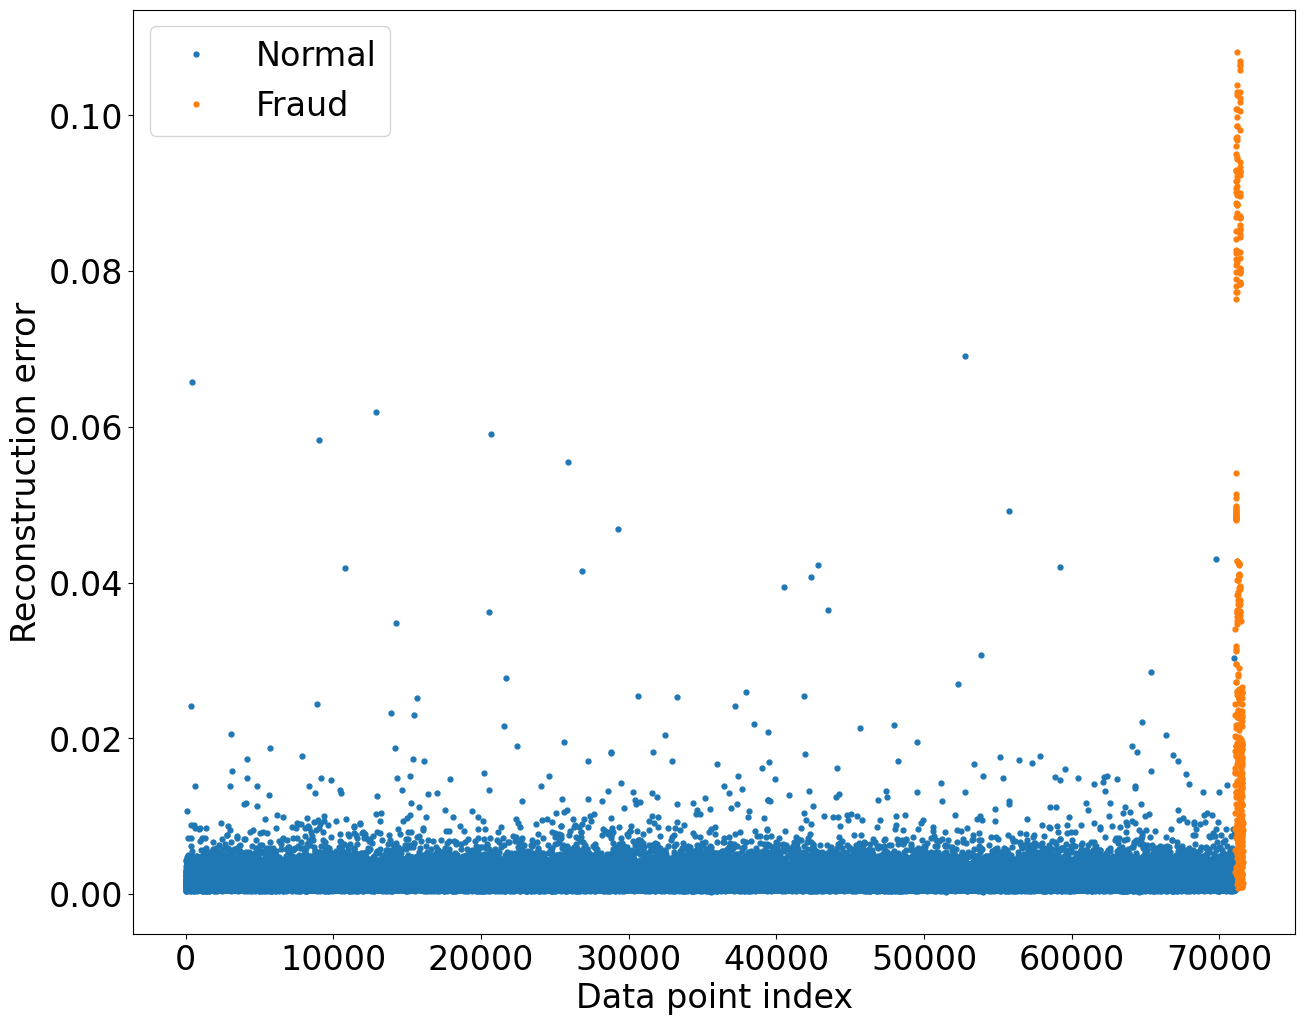

In [25]:
#####RE for different classes of data

group1 = tst_error_data.groupby('Class')
fig, ax = plt.subplots()
for name, group in group1:
    ax.plot(group.index, group.recon_error, marker='o', ms=3.5, linestyle='',label= "Fraud" if name == 1 else "Normal")
ax.legend()
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

# How well does the unsupervised classifier work (Metric analysis)?

In [26]:
# Compute confusion matrix for test data (fraud+normal)
import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,roc_curve, recall_score, classification_report, f1_score,precision_recall_fscore_support)

threshold=0.0034 ##selected using trial and error based on improving the TPR and TNR values

y_pred = [1 if e > threshold else 0 for e in tst_error_data.recon_error.values]

cm= confusion_matrix(tst_error_data.Class, y_pred)
print("Confusion matrix:")
print(cm)

tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

print("\nTotal number of true positives", tp)
print("Total number of false negatives",fn)
print("Total number of false positives",fp)
print("Total number of true negatives",tn)

acc=float(tp+tn)/(tp+tn+fp+fn)

print('\nClassifier Accuracy: %.2f%%' % (acc * 100))

tpr = float(tp)/(tp+fn)

print('True Positive Rate (TPR/Recall/Sensitivity): %.2f%%' % (tpr * 100))

specificity = float (tn)/(tn+fp)

print ("True Negative Rate (TNR/Specificity/selectivity):%.2f%%" % (specificity*100))

fpr = float(fp)/(fp+tn)
print("False Positive Rate (FPR): %.2f%%" % (fpr * 100))

fnr = fn/ (fn+ tp)
print("False Negative Rate (FNR): %.2f%%" % (fnr*100))

precision=float(tp)/(tp+fp)
print("Precision/Positive Predictive value:%.2f%%" %(precision*100))

fscore = 2*((precision*tpr)/(precision+tpr))
print("F1-Score: %.2f%%" %(fscore*100))


Confusion matrix:
[[64615  6464]
 [   58   434]]

Total number of true positives 434
Total number of false negatives 58
Total number of false positives 6464
Total number of true negatives 64615

Classifier Accuracy: 90.89%
True Positive Rate (TPR/Recall/Sensitivity): 88.21%
True Negative Rate (TNR/Specificity/selectivity):90.91%
False Positive Rate (FPR): 9.09%
False Negative Rate (FNR): 11.79%
Precision/Positive Predictive value:6.29%
F1-Score: 11.75%


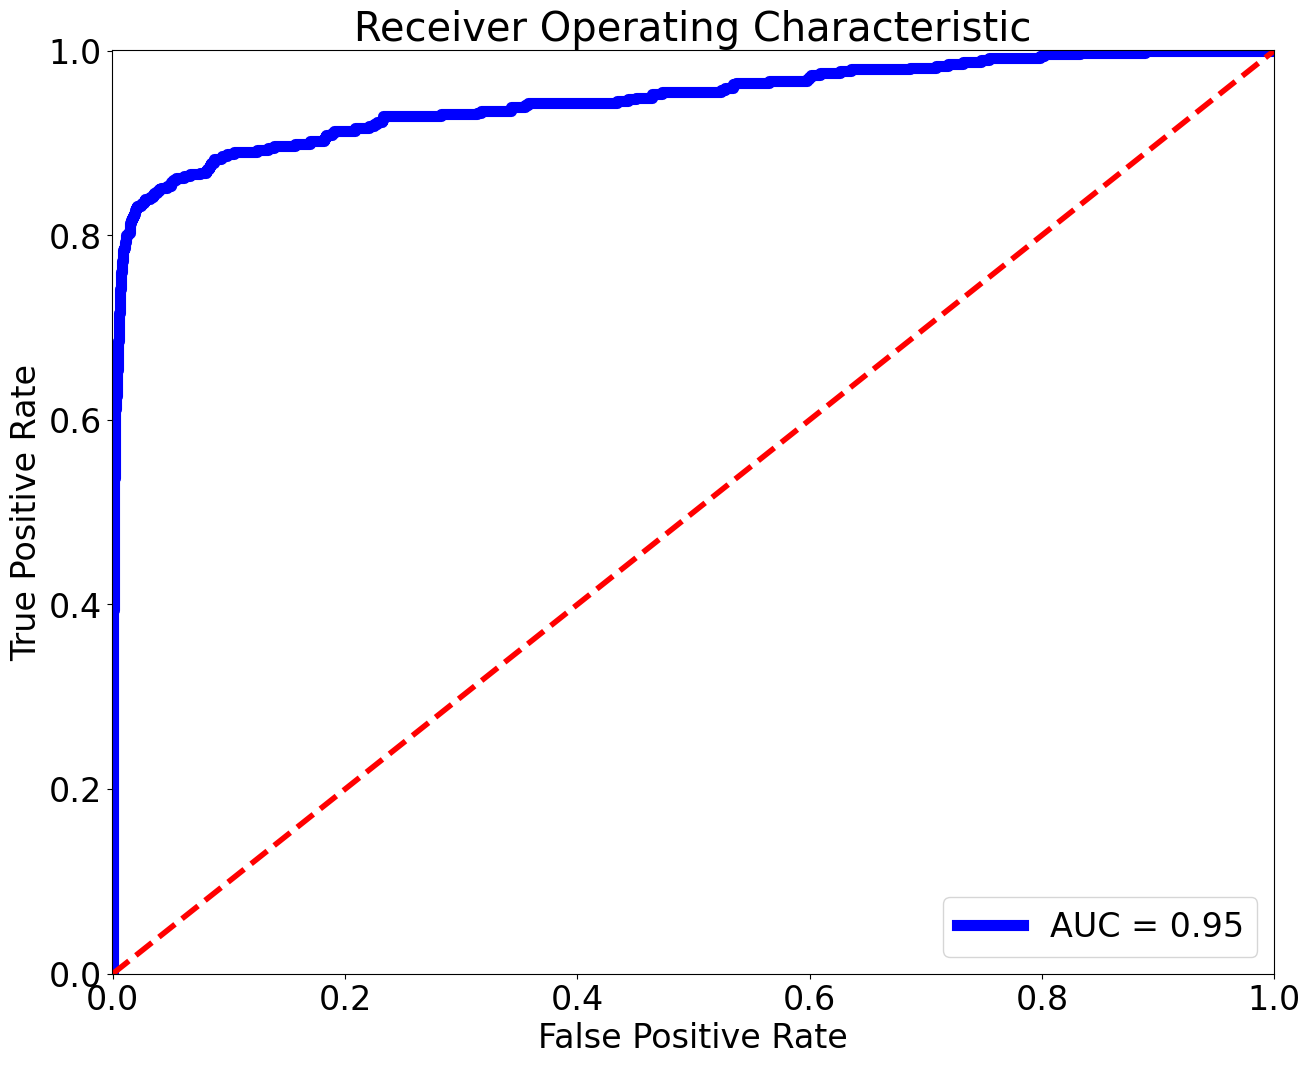

In [27]:
##########ROC GRAPH#######

fpr, tpr, thresholds = roc_curve(tst_error_data.Class,tst_error_data.recon_error)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc,linewidth = 8, color='b')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--',linewidth = 4)
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()